# Product Classification with Keras

A brief exploration into the performance of an artificial neural net with keras on the Otto Group dataset. 

Dataset: Otto product classification (https://www.kaggle.com/c/otto-group-product-classification-challenge)
- 9 product categories.
- Counts of 93 anonymous events.
- Almost 62,000 products.


Approach:
1. A bit of data prep.
2. Build and fit network.
3. Evaluate with Kfold cross-validation.

Performance:
- =<78% accuracy.
- A large amount of overfitting, possibly from 'relu' activation function, number of nodes or data.

In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('data/train.csv')
df.shape

(61878, 95)

First up, preparing the dataset for model fitting.

1. One-hot encoded classes.
2. Build and split features (X) and target (y).
3. Scale features, incase there's a potential bias there.

In [2]:
df.target.unique()

array(['Class_1', 'Class_2', 'Class_3', 'Class_4', 'Class_5', 'Class_6',
       'Class_7', 'Class_8', 'Class_9'], dtype=object)

In [3]:
# it's easy enough to encode the classes without an extra module
df['target'] = [x[-1] for x in df['target']]
df['target'] = df['target'].astype(int) - 1
df.target.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=int64)

In [4]:
# slice features and classes from df
X = df.iloc[:, 1:94].values.astype(float)
y = df.iloc[:, 94].values.astype(float)

In [5]:
from sklearn.model_selection import train_test_split

# split X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [6]:
from sklearn.preprocessing import StandardScaler

# scale features
sc = StandardScaler()
X = sc.fit_transform(X)
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

Next, build out a pretty basic artificial neural net. 

- 8 hidden layers with a decent number of nodes to help spot potentially complex patterns in the events data.
- 'rmsprop' works pretty well as an alternative to adam gradient decent.
- Using the sparse version of crossentropy means we don't have to encode the classes.

In [7]:
import keras
from keras.models import Sequential
from keras.layers import Dense

def classifier():
    # initialising the ANN
    classifier = Sequential()
    # input and hidden layers
    classifier.add(Dense(units = 200, kernel_initializer = 'uniform', activation = 'relu', input_dim = 93))
    classifier.add(Dense(units = 175, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 150, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 125, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 100, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 75, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 50, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 25, kernel_initializer = 'uniform', activation = 'relu'))
    # output layer
    classifier.add(Dense(units = 9, kernel_initializer = 'uniform', activation = 'softmax'))
    # compile network
    classifier.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return classifier

C:\Users\Oliver\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Let's fit with validation included so we can evaluate performance right away, and decent batch size should help it move along reasonably swiftly.

In [8]:
classifier = classifier()
history = classifier.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100, batch_size=1000)

Train on 49502 samples, validate on 12376 samples
Epoch 1/100
49502/49502 [==============================] - 2s 44us/step - loss: 1.7637 - acc: 0.2304 - val_loss: 1.6239 - val_acc: 0.2263
Epoch 2/100
49502/49502 [==============================] - 2s 35us/step - loss: 1.5382 - acc: 0.3212 - val_loss: 1.4543 - val_acc: 0.3467
Epoch 3/100
49502/49502 [==============================] - 2s 34us/step - loss: 1.3214 - acc: 0.4672 - val_loss: 1.1546 - val_acc: 0.5473
Epoch 4/100
49502/49502 [==============================] - 2s 34us/step - loss: 1.0755 - acc: 0.6128 - val_loss: 0.9275 - val_acc: 0.6590
Epoch 5/100
49502/49502 [==============================] - 2s 33us/step - loss: 1.0124 - acc: 0.6280 - val_loss: 0.9343 - val_acc: 0.6698
Epoch 6/100
49502/49502 [==============================] - 2s 32us/step - loss: 0.9400 - acc: 0.6723 - val_loss: 0.8533 - val_acc: 0.7106
Epoch 7/100
49502/49502 [==============================] - 2s 34us/step - loss: 0.8939 - acc: 0.6887 - val_loss: 0.9480 - 

Validated loss has exploded faster than a mentos dropped in coke, let's take a look.

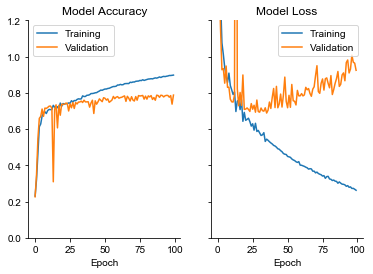

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def plots(acc, val_acc, loss, val_loss):
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

    # plot accuracy
    ax1.plot(acc, label='Training')
    if val_acc is not None:
        ax1.plot(val_acc, label='Validation')

    ax1.set_xlabel('Epoch')
    ax1.set_title('Model Accuracy')
    ax1.legend(loc='upper left')
    ax1.set_ylim([0,1.2])

    # plot loss
    ax2.plot(loss, label='Training')
    if val_loss is not None:
        ax2.plot(val_loss, label='Validation')

    ax2.set_xlabel('Epoch')
    ax2.set_title('Model Loss')
    ax2.legend(loc='upper right')
    ax2.set_ylim([0,1.2])

    sns.despine()
    sns.set_style("white")


    plt.show()

plots(history.history["acc"],history.history['val_acc'],history.history["loss"],history.history['val_loss'])

The classifier appears to be overfitting the training set around the 30-40th epoch, where the validation loss becomes pretty violent. Lets add an early-stop and re-fit.

In [13]:
def classifier():
    '''initialise the same classifier as before'''
    # initialising the ANN
    classifier = Sequential()
    # input and hidden layers
    classifier.add(Dense(units = 200, kernel_initializer = 'uniform', activation = 'relu', input_dim = 93))
    classifier.add(Dense(units = 175, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 150, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 125, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 100, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 75, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 50, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 25, kernel_initializer = 'uniform', activation = 'relu'))
    # output layer
    classifier.add(Dense(units = 9, kernel_initializer = 'uniform', activation = 'softmax'))
    # compile network
    classifier.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    return classifier

In [21]:
from keras.callbacks import EarlyStopping

classifier_es = classifier()
early_stop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=4,
                              verbose=0, mode='auto')

history_es = classifier_es.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100, batch_size=1000, callbacks=[early_stop])

Train on 49502 samples, validate on 12376 samples
Epoch 1/100
49502/49502 [==============================] - 2s 35us/step - loss: 1.7782 - acc: 0.2329 - val_loss: 1.6279 - val_acc: 0.2266
Epoch 2/100
49502/49502 [==============================] - 1s 23us/step - loss: 1.5741 - acc: 0.2593 - val_loss: 1.5500 - val_acc: 0.2509
Epoch 3/100
49502/49502 [==============================] - 1s 23us/step - loss: 1.3509 - acc: 0.4244 - val_loss: 1.1713 - val_acc: 0.6384
Epoch 4/100
49502/49502 [==============================] - 1s 24us/step - loss: 1.0477 - acc: 0.6350 - val_loss: 1.0727 - val_acc: 0.6133
Epoch 5/100
49502/49502 [==============================] - 1s 25us/step - loss: 1.0416 - acc: 0.6306 - val_loss: 0.9118 - val_acc: 0.6644
Epoch 6/100
49502/49502 [==============================] - 1s 24us/step - loss: 0.9632 - acc: 0.6482 - val_loss: 0.8901 - val_acc: 0.6723
Epoch 7/100
49502/49502 [==============================] - 1s 24us/step - loss: 0.8600 - acc: 0.6712 - val_loss: 0.8798 - 

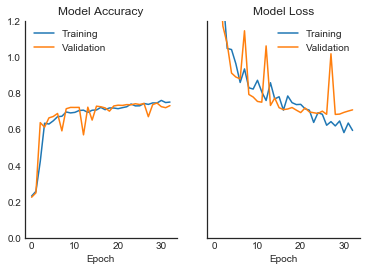

In [22]:
plots(history_es.history["acc"],history_es.history['val_acc'],history_es.history["loss"],history_es.history['val_loss'])

So we have stopped where we expected, but the results fluctuate between 60% and 75% validated accuracy after serveral run throughs.

There are also large, regular spikes in the validated loss. It could be overfitting due to the relu activation function, too many hidden layer nodes or possibly that there are a number of odd cases in the data.

Finally, let's perform an alternative evaluation with 10-fold cross-validation.

In [23]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold, cross_val_score

# build estimator, making model compatible with sklearn modules
estimator = KerasClassifier(build_fn=classifier, epochs=100, batch_size=1000, verbose=0)


kfold = KFold(n_splits=10, shuffle=True, random_state=1)
%time results = cross_val_score(estimator, X, y, cv=kfold, scoring='accuracy')
print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Wall time: 18min 37s
Accuracy: 78.25% (0.74%)


This run was computationally expensive, but thoroughly tests the model on different sets of unseen data. A stratified kfold might squeeze a little extra by balancing up the share of classes, but we already have a reasonable picture of performance.

Next steps might be to experiment with the hidden layers and activation functions to achieve a more accurate and stable build.